# Análise Exploratória de Dados Climáticos e de Uso do Solo

- Andressa Silva de Oliveira
- Fabrício Neri Lima
- Isabelle Moschini Murollo
- Vinicius Grando Eller

## Contextualização e Importância do Tema

No contexto atual, os eventos climáticos extremos têm se tornado mais frequentes e intensos, trazendo consequências devastadoras para a população, a biodiversidade e as economias mundiais. Essa tendência está relacionada às mudanças climáticas globais, as quais são influenciadas por fatores como desmatamento, urbanização crescente e emissões de gases de efeito estufa. Nesse sentido, a investigação da relação entre esses eventos e os locais onde eles ocorrem é de grande importância para compreender os impactos ambientais e socioeconômicos relacionados, permitindo o desenvolvimento de estratégias mais eficazes para a sua mitigação.

Sendo assim, este projeto explora a conexão entre eventos climáticos extremos e variáveis ambientais diversas, como aumento de áreas de plantio e degradação de florestas. Para isso, foram utilizadas as seguintes bases de dados: FAO (Land Cover and Forest Area), que fornece informações detalhadas sobre cobertura terrestre e áreas florestais, e EM-DAT, que documenta desastres naturais em escala global. Essas fontes são robustas e permitem avaliar padrões globais, além de realizar comparações regionais e históricas, contribuindo para a identificação de tendências e hotspots climáticos, os quais demandam maior atenção.

Dessa forma, objetiva-se, com este estudo, entender as causas e as consequências da interação entre fatores naturais e humanos e fornecer insights que possam vir a embasar políticas públicas e iniciativas sustentáveis. Ainda, a análise dessas relações é relevante nas circunstâncias atuais, em que a humanidade enfrenta desafios como o aumento das desigualdades climáticas e a necessidade de adoção de práticas ambientais mais responsáveis. Nesse sentido, este projeto busca, além de gerar insights de relevância ao contexto descrito, destacar a importância do uso da ciência de dados na geração de soluções para questões climáticas globais.


### Origem das Bases de Dados Utilizadas
Para o desenvolvimento das análises contidas neste projeto, utilizou-se duas bases de dados, sendo elas: FAO (Land Cover and Forest Area) e EM-DAT (Emergency Events Database). A primeira base contém dados anuais de 1992-2020 sobre o uso da terra, incluindo tipos de cobertura e índices que influenciam o clima, tendo sido publicada em 2022 pela FAOSTAT (Food and Agriculture Organization Statistics). A FAOSTAT é uma base de dados global da Organização das Nações Unidas para a Alimentação e a Agricultura (FAO) que oferece estatísticas agrícolas, alimentares e ambientais de países, desde 1961. 

Já a segunda base apresenta dados sobre o número e tipos de desastres naturais, agrupados anualmente, permitindo análise da frequência e intensidade de eventos climáticos ao longo do tempo, tendo sido publicada pelo EM-DAT (Emergency Events Database) em 2023. O EM-DAT é uma base global criada pelo Centro de Pesquisa sobre a Epidemiologia de Desastres (CRED), a qual registra e analisa dados sobre desastres naturais e tecnológicos.


### Referências

Artigos que Utilizam a Base de Land Cover e Forest Area (FAO):
1. ROSAN, T. M. et al. A multi-data assessment of land use and land cover emissions from Brazil during 2000–2019. 2021 Environ. Res. Lett. 16 074004. Disponível em: <https://iopscience.iop.org/article/10.1088/1748-9326/ac08c3/meta>
2. DOOLEY, K. et al.. Over-reliance on land for carbon dioxide removal in net-zero climate pledges. Nature Communications (2024) 15:9118. 23 out. 2024. Disponível em: <https://www.nature.com/articles/s41467-024-53466-0>
3. REINER, F. et al. More than one quarter of Africa’s tree cover is found outside areas previously classified as forest. Nature Communications (2023) 14:2258. 29 mar. 2023. Disponível em: <https://www.nature.com/articles/s41467-023-37880-4>


Artigos que Utilizam a Base de Desastres Climáticos Extremos (EM-DAT):

1. NEWMAN, R.; NOY, I. The global costs of extreme weather that are attributable to climate change. Nature Communications (2023) 14:6103. 29 set. 2023. Disponível em: <https://www.nature.com/articles/s41467-023-41888-1>
2. DONG, C. Indo-Pacific regional extremes aggravated by changes in tropical weather patterns. Nature Geoscience. Volume 17 979–986. 4 out. 2024. Disponível em: <https://www.nature.com/articles/s41561-024-01537-8>
3. BALAIAN, S. K.; SANDERS, B. F.; QOMI, M. J. A. How urban form impacts flooding. Nature Communications (2024) 15:6911. 19 ago. 2024. Disponível em: <https://www.nature.com/articles/s41467-024-50347-4>


## Objetivo da Análise

Esta análise tem como objetivo explorar dados combinados de duas diferentes bases, de forma a identificar relações entre aspectos climáticos e territoriais e a corrência de desastres ambientais ao redor do mundo. Em especial, foram levantadas as seguintes perguntas iniciais, a serem respondidas:
- Qual país com mais emissões de CO2?
- Qual país que mais teve desastres naturais nos últimos 5 anos?
- Quais os principais tipos de desastres naturais?
- Qual o ano em que aconteceu mais desastres?
- Há uma tendência de aumento no número de desastres ao longo dos anos?


# Import e Preparação dos Dados

Para iniciar o processo, são importadas as bibliotecas a serem usadas.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import math

Como primeiro passo, após os imports das bibliotecas necessárias, vamos realizar a importação da base de dados.

In [3]:
data = pd.read_csv("data/processed/dataConcat_gold.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/dataConcat_gold.csv'

In [ ]:
data.head(5)

,country,iso2,iso3,year,Artificialsurfaces(includingurbanandassociatedareas)_1000HA,Carbonstocksinforests_Milliontonnes,ClimateAlteringLandCoverIndex_Index,"Climaterelateddisastersfrequency,NumberofDisasters:Drought_Numberof","Climaterelateddisastersfrequency,NumberofDisasters:Extremetemperature_Numberof","Climaterelateddisastersfrequency,NumberofDisasters:Flood_Numberof",...,Mangroves_1000HA,Permanentsnowandglaciers_1000HA,Shareofforestarea_Percent,Shrub-coveredareas_1000HA,"Shrubsand/orherbaceousvegetation,aquaticorregularlyflooded_1000HA",Sparselynaturalvegetatedareas_1000HA,"Temperaturechangewithrespecttoabaselineclimatology,correspondingtotheperiod1951-1980_DegreeCelsius",Terrestrialbarrenland_1000HA,Tree-coveredareas_1000HA,Woodycrops_1000HA
0,"Afghanistan, Islamic Rep. of",AF,AFG,1961,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.126,NaN,NaN,NaN
1,"Afghanistan, Islamic Rep. of",AF,AFG,1962,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.173,NaN,NaN,NaN
2,"Afghanistan, Islamic Rep. of",AF,AFG,1963,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.844,NaN,NaN,NaN
3,"Afghanistan, Islamic Rep. of",AF,AFG,1964,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.751,NaN,NaN,NaN
4,"Afghanistan, Islamic Rep. of",AF,AFG,1965,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.220,NaN,NaN,NaN


Como primeira etapa da análise, vamos ver o resumo do dataset através do método info(). Um beneficio desse método é conseguir ver a tipagem de cada coluna, para necessidades como limpeza, e etc.

In [ ]:
data.info()  # Informações sobre colunas, tipos e valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13451 entries, 0 to 13450
Data columns (total 31 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   country                                                                                             13451 non-null  object 
 1   iso2                                                                                                13451 non-null  object 
 2   iso3                                                                                                13451 non-null  object 
 3   year                                                                                                13451 non-null  int64  
 4   Artificialsurfaces(includingurbanandassociatedareas)_1000HA                                         7068 non-nul

Abaixo podemos perceber que temos uma quantidade de 13451 linhas e 31 features.

In [ ]:
data.shape  # Número de linhas e colunas

(13451, 31)

Quando fazemos um print do nome das colunas, podemos perceber que não necessariamente temos clareza do que significam. Por isso, vamos fazer um processo de renomeá-las:

In [ ]:
data.columns

Index(['country', 'iso2', 'iso3', 'year',
       'Artificialsurfaces(includingurbanandassociatedareas)_1000HA',
       'Carbonstocksinforests_Milliontonnes',
       'ClimateAlteringLandCoverIndex_Index',
       'Climaterelateddisastersfrequency,NumberofDisasters:Drought_Numberof',
       'Climaterelateddisastersfrequency,NumberofDisasters:Extremetemperature_Numberof',
       'Climaterelateddisastersfrequency,NumberofDisasters:Flood_Numberof',
       'Climaterelateddisastersfrequency,NumberofDisasters:Landslide_Numberof',
       'Climaterelateddisastersfrequency,NumberofDisasters:Storm_Numberof',
       'Climaterelateddisastersfrequency,NumberofDisasters:TOTAL_Numberof',
       'Climaterelateddisastersfrequency,NumberofDisasters:Wildfire_Numberof',
       'Forestarea_1000HA', 'Grassland_1000HA', 'Herbaceouscrops_1000HA',
       'Indexofcarbonstocksinforests_Index', 'Indexofforestextent_Index',
       'Inlandwaterbodies_1000HA', 'Landarea_1000HA', 'Mangroves_1000HA',
       'Permanentsno

In [ ]:
# Lista de nomes das colunas antes da transformação
colunas_originais = [
    'country', 'iso2', 'iso3', 'year',
    'Artificialsurfaces(includingurbanandassociatedareas)_1000HA',
    'Carbonstocksinforests_Milliontonnes',
    'ClimateAlteringLandCoverIndex_Index',
    'Climaterelateddisastersfrequency,NumberofDisasters:Drought_Numberof',
    'Climaterelateddisastersfrequency,NumberofDisasters:Extremetemperature_Numberof',
    'Climaterelateddisastersfrequency,NumberofDisasters:Flood_Numberof',
    'Climaterelateddisastersfrequency,NumberofDisasters:Landslide_Numberof',
    'Climaterelateddisastersfrequency,NumberofDisasters:Storm_Numberof',
    'Climaterelateddisastersfrequency,NumberofDisasters:TOTAL_Numberof',
    'Climaterelateddisastersfrequency,NumberofDisasters:Wildfire_Numberof',
    'Forestarea_1000HA', 'Grassland_1000HA', 'Herbaceouscrops_1000HA',
    'Indexofcarbonstocksinforests_Index', 'Indexofforestextent_Index',
    'Inlandwaterbodies_1000HA', 'Landarea_1000HA', 'Mangroves_1000HA',
    'Permanentsnowandglaciers_1000HA', 'Shareofforestarea_Percent',
    'Shrub-coveredareas_1000HA',
    'Shrubsand/orherbaceousvegetation,aquaticorregularlyflooded_1000HA',
    'Sparselynaturalvegetatedareas_1000HA',
    'Temperaturechangewithrespecttoabaselineclimatology,correspondingtotheperiod1951-1980_DegreeCelsius',
    'Terrestrialbarrenland_1000HA', 'Tree-coveredareas_1000HA',
    'Woodycrops_1000HA'
]

In [ ]:
# Colunas com nomes mais legíveis
colunas_melhoradas = [
    'country', 'iso2', 'iso3', 'year',
    'artificial_surfaces_1000ha',
    'carbon_stocks_in_forests_million_tonnes',
    'climate_altering_land_cover_index',
    'disasters_drought_number',
    'disasters_extreme_temperature_number',
    'disasters_flood_number',
    'disasters_landslide_number',
    'disasters_storm_number',
    'disasters_total_number',
    'disasters_wildfire_number',
    'forest_area_1000ha', 'grassland_1000ha', 'herbaceous_crops_1000ha',
    'carbon_stocks_index', 'forest_extent_index',
    'inland_water_bodies_1000ha', 'land_area_1000ha', 'mangroves_1000ha',
    'permanent_snow_and_glaciers_1000ha', 'share_of_forest_area_percent',
    'shrub_covered_areas_1000ha',
    'flooded_shrubs_or_herbaceous_vegetation_1000ha',
    'sparsely_natural_vegetated_areas_1000ha',
    'temperature_change_since_1951_1980_celsius',
    'terrestrial_barren_land_1000ha', 'tree_covered_areas_1000ha',
    'woody_crops_1000ha'
]

In [ ]:
data.columns = colunas_melhoradas

O tratamento deixa a leitura mais legível e de fácil compreensão, como pode ser visto abaixo:

In [ ]:
data.columns

Index(['country', 'iso2', 'iso3', 'year', 'artificial_surfaces_1000ha',
       'carbon_stocks_in_forests_million_tonnes',
       'climate_altering_land_cover_index', 'disasters_drought_number',
       'disasters_extreme_temperature_number', 'disasters_flood_number',
       'disasters_landslide_number', 'disasters_storm_number',
       'disasters_total_number', 'disasters_wildfire_number',
       'forest_area_1000ha', 'grassland_1000ha', 'herbaceous_crops_1000ha',
       'carbon_stocks_index', 'forest_extent_index',
       'inland_water_bodies_1000ha', 'land_area_1000ha', 'mangroves_1000ha',
       'permanent_snow_and_glaciers_1000ha', 'share_of_forest_area_percent',
       'shrub_covered_areas_1000ha',
       'flooded_shrubs_or_herbaceous_vegetation_1000ha',
       'sparsely_natural_vegetated_areas_1000ha',
       'temperature_change_since_1951_1980_celsius',
       'terrestrial_barren_land_1000ha', 'tree_covered_areas_1000ha',
       'woody_crops_1000ha'],
      dtype='object')

In [ ]:
data.info()  # Informações sobre colunas, tipos e valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13451 entries, 0 to 13450
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   country                                         13451 non-null  object 
 1   iso2                                            13451 non-null  object 
 2   iso3                                            13451 non-null  object 
 3   year                                            13451 non-null  int64  
 4   artificial_surfaces_1000ha                      7068 non-null   float64
 5   carbon_stocks_in_forests_million_tonnes         5717 non-null   float64
 6   climate_altering_land_cover_index               6977 non-null   float64
 7   disasters_drought_number                        638 non-null    float64
 8   disasters_extreme_temperature_number            501 non-null    float64
 9   disasters_flood_number                 

O describe() vai mostrar um resumo estatístico dos dados numéricos presentes no dataframe.

In [ ]:
data.describe()

,year,artificial_surfaces_1000ha,carbon_stocks_in_forests_million_tonnes,climate_altering_land_cover_index,disasters_drought_number,disasters_extreme_temperature_number,disasters_flood_number,disasters_landslide_number,disasters_storm_number,disasters_total_number,...,mangroves_1000ha,permanent_snow_and_glaciers_1000ha,share_of_forest_area_percent,shrub_covered_areas_1000ha,flooded_shrubs_or_herbaceous_vegetation_1000ha,sparsely_natural_vegetated_areas_1000ha,temperature_change_since_1951_1980_celsius,terrestrial_barren_land_1000ha,tree_covered_areas_1000ha,woody_crops_1000ha
count,13451.000000,7068.000000,5717.000000,6977.000000,638.000000,501.000000,2732.000000,480.000000,1789.000000,4173.000000,...,7068.000000,7068.000000,6796.000000,7068.000000,7068.000000,7068.000000,12744.000000,7068.000000,7068.000000,7068.000000
mean,1993.494387,190.622145,1747.422397,99.694895,1.025078,1.163673,1.953514,1.404167,2.181666,5.594776,...,79.332600,984.177900,33.927982,6801.298912,836.973089,3879.792864,0.553962,8144.878121,18696.816873,923.647617
std,18.063252,802.744898,6382.910503,35.259589,0.175406,0.420901,1.862649,0.814267,2.687900,28.796962,...,340.713737,11653.462814,24.921772,24214.132767,5738.973996,22059.236024,0.679600,27951.258773,79797.430121,2941.772399
min,1961.000000,0.000000,0.000000,25.349011,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.251000,0.000000,0.000000,0.000000
25%,1978.000000,1.737500,12.410000,96.001943,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,11.618342,7.027500,0.060000,0.050000,0.068000,0.000000,37.160000,4.180000
50%,1995.000000,21.405000,153.016800,99.837942,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,33.133087,215.570000,6.510000,3.550000,0.482500,2.850000,1252.035000,104.260000
75%,2009.000000,92.295000,802.693000,100.686624,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,...,17.100000,0.000000,52.222222,2305.422500,111.617500,156.835000,0.976000,416.882500,8355.837500,462.340000
max,2023.000000,11845.390000,58129.141200,740.012265,3.000000,3.000000,25.000000,8.000000,27.000000,407.000000,...,4117.390000,175240.000000,98.002611,202541.920000,87681.500000,284361.000000,5.327000,209518.260000,955922.990000,32065.460000


In [ ]:
data.isnull().sum()  # Total de valores nulos por coluna

country                                               0
iso2                                                  0
iso3                                                  0
year                                                  0
artificial_surfaces_1000ha                         6383
carbon_stocks_in_forests_million_tonnes            7734
climate_altering_land_cover_index                  6474
disasters_drought_number                          12813
disasters_extreme_temperature_number              12950
disasters_flood_number                            10719
disasters_landslide_number                        12971
disasters_storm_number                            11662
disasters_total_number                             9278
disasters_wildfire_number                         13113
forest_area_1000ha                                 6536
grassland_1000ha                                   6383
herbaceous_crops_1000ha                            6383
carbon_stocks_index                             

Podem ser levantadas algumas hipóteses em relação ao comportamento dos dados de maneira preliminar. Para os desastres naturais, por exemplo, é esperado que haja uma grande quantidade de dados faltantes. Na verdade, eles não são faltantes, mas a sua ausência apenas demonstra que não houve algum evento extremo naquele país durante aquele ano, o que é esperado uma vez que eventos extremos deveriam ser pouco comuns.

In [ ]:
data.isnull().mean() * 100  

country                                            0.000000
iso2                                               0.000000
iso3                                               0.000000
year                                               0.000000
artificial_surfaces_1000ha                        47.453721
carbon_stocks_in_forests_million_tonnes           57.497584
climate_altering_land_cover_index                 48.130251
disasters_drought_number                          95.256858
disasters_extreme_temperature_number              96.275370
disasters_flood_number                            79.689242
disasters_landslide_number                        96.431492
disasters_storm_number                            86.699874
disasters_total_number                            68.976284
disasters_wildfire_number                         97.487176
forest_area_1000ha                                48.591183
grassland_1000ha                                  47.453721
herbaceous_crops_1000ha                 

A hipótese acima pode ser verdade para dados como desastres climáticos intensos, mas quando olhamos para a porcentagem dos outros dados, parece haver um excesso de dados faltantes. Pode ser necessário recortar temporalmente o dataset de modo a ter dados mais relevantes. Vamos agora analisar de maneira gráfica o comportamento dos dados e como eles estão distribuídos.

Primeiro, vamos preencher os valores faltantes das colunas de desastres climáticos com zeros.

In [ ]:
colunas_para_preencher = ['disasters_drought_number','disasters_extreme_temperature_number','disasters_flood_number','disasters_landslide_number',
'disasters_storm_number','disasters_total_number','disasters_wildfire_number']

data[colunas_para_preencher] = data[colunas_para_preencher].fillna(0)

In [ ]:
data.isnull().mean() * 100

country                                            0.000000
iso2                                               0.000000
iso3                                               0.000000
year                                               0.000000
artificial_surfaces_1000ha                        47.453721
carbon_stocks_in_forests_million_tonnes           57.497584
climate_altering_land_cover_index                 48.130251
disasters_drought_number                           0.000000
disasters_extreme_temperature_number               0.000000
disasters_flood_number                             0.000000
disasters_landslide_number                         0.000000
disasters_storm_number                             0.000000
disasters_total_number                             0.000000
disasters_wildfire_number                          0.000000
forest_area_1000ha                                48.591183
grassland_1000ha                                  47.453721
herbaceous_crops_1000ha                 

## Histogramas para cada variável

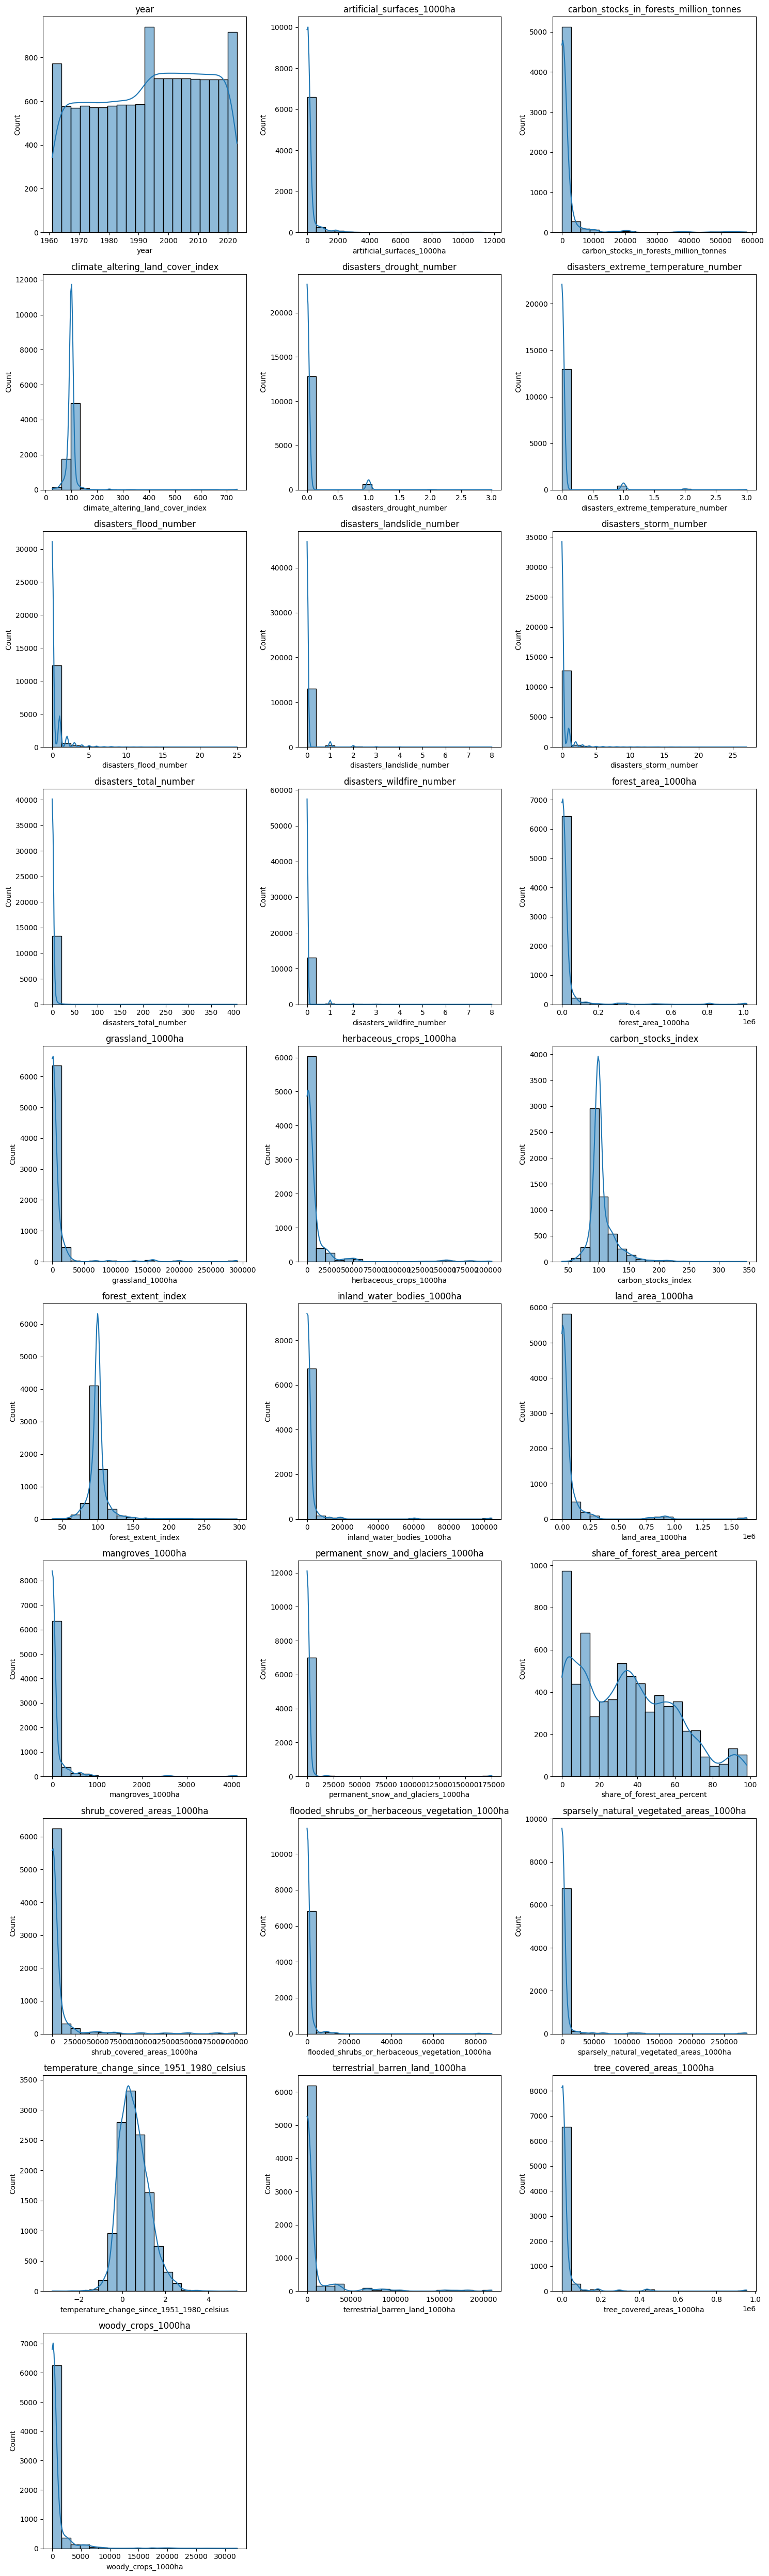

In [ ]:
# Histogramas individuais com FacetGrid
num_cols = data.select_dtypes(include=['float64', 'int']).columns  # Apenas colunas numéricas
num_plots = len(num_cols)
cols = 3  # Número de gráficos por linha
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Define o tamanho total
axes = axes.flatten()  # Achata a matriz de eixos

for i, col in enumerate(num_cols):
    sns.histplot(data[col], bins=20, ax=axes[i], kde=True)
    axes[i].set_title(col)

# Remove gráficos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Matriz de correlação 

In [ ]:
# Filtrar apenas colunas numéricas
corr = data.select_dtypes(include=['float64', 'int']).corr()

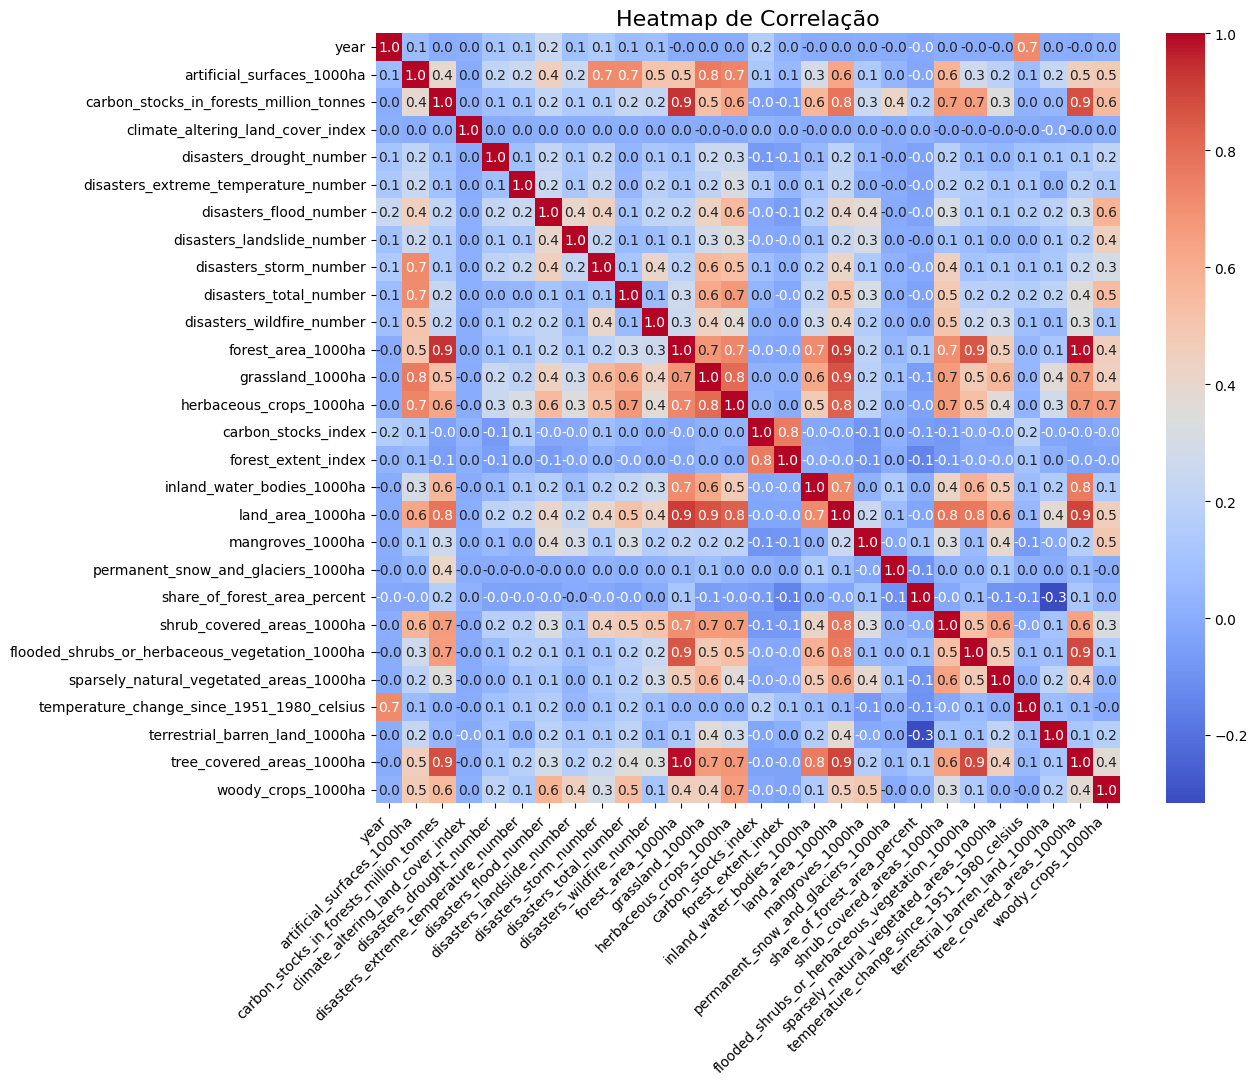

In [ ]:
plt.figure(figsize=(12, 10))  # Ajusta o tamanho do gráfico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f")  # Reduz para 2 casas decimais
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo X
plt.yticks(rotation=0)  # Mantém os rótulos do eixo Y horizontais
plt.title('Heatmap de Correlação', fontsize=16)  # Adiciona um título
plt.show()

A matriz de correlação demonstra de maneira generalizada o comportamento de correlação das variáveis considerando os países do mundo inteiro. Como esperado, algumas relações são fortes, como os Estoques de Carbono em Florestas com Áreas de Floresta, além de uma relação média-forte entre desastres climáticos e áreas de superfície artificial (cidades).

Ao investigar o dataset, foi encontrado que para grande parte dos países, apenas uma coluna possui dados históricos, causando uma grande quantidade de linhas com poucos dados.

[ inserir imagem da tabela ] 

## Investigação dos dados faltantes

In [ ]:
faltantes_por_linha = data.isnull().sum(axis=1)
linhas_com_2_ou_mais_faltantes = data[faltantes_por_linha >= 2]
faltantes_por_ano = linhas_com_2_ou_mais_faltantes.groupby('year').size()

In [ ]:
faltantes_por_ano

year
1961    193
1962    194
1963    193
1964    192
1965    191
       ... 
2019     41
2020     41
2021    233
2022    233
2023    219
Length: 63, dtype: int64

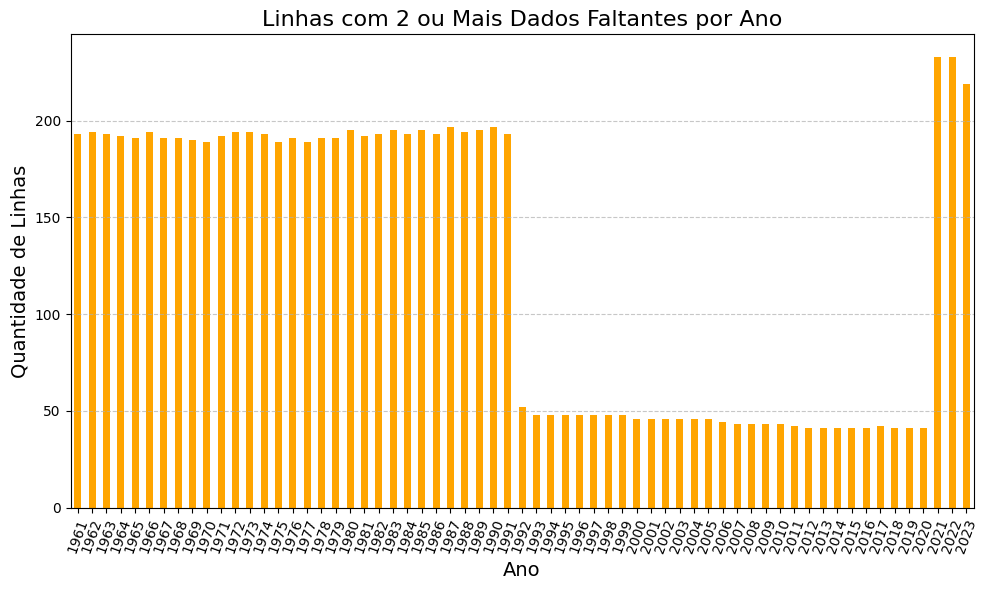

In [ ]:
faltantes_por_ano.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Linhas com 2 ou Mais Dados Faltantes por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Quantidade de Linhas', fontsize=14)
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
faltantes_por_linha = data.isnull().sum(axis=1)
linhas_com_15_ou_mais_faltantes = data[faltantes_por_linha >= 15]
faltantes_por_ano = linhas_com_15_ou_mais_faltantes.groupby('year').size()

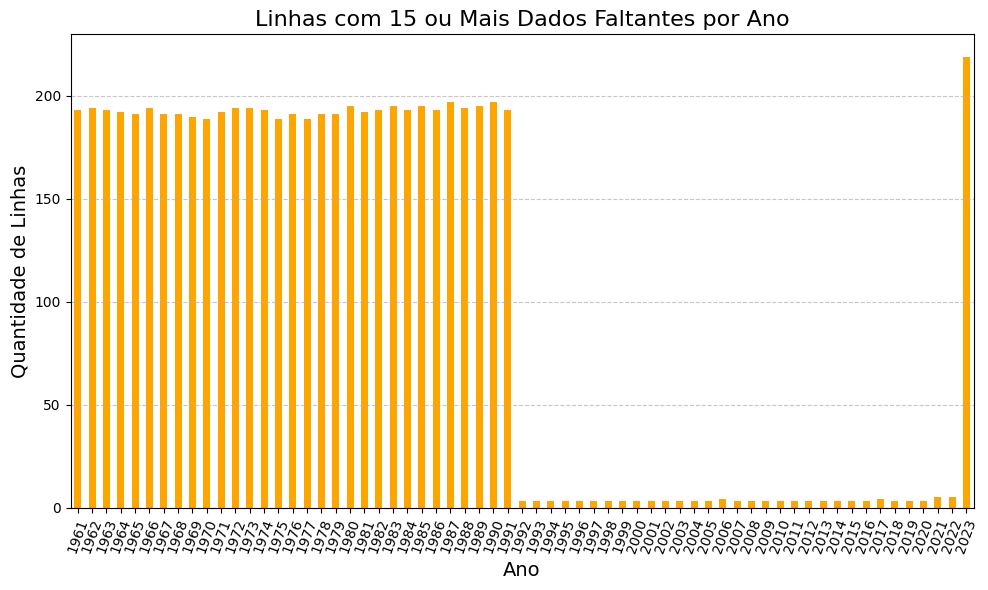

In [ ]:
faltantes_por_ano.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Linhas com 15 ou Mais Dados Faltantes por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Quantidade de Linhas', fontsize=14)
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Por conta do numero de dados faltantes nas colunas antes de 1992 e em 2023, foi decidido dropar as linhas com esses dados. Isso porque havia uma ausência muito grande de dados.

In [ ]:
# Conta o número de valores faltantes em cada linha
faltantes_por_linha = data.isnull().sum(axis=1)
# Filtra apenas as linhas com menos de 2 valores faltantes
new_data = data[faltantes_por_linha < 15]

# Exibindo o tamanho do dataset antes e depois
print(f"Tamanho original do dataset: {data.shape[0]} linhas")
print(f"Tamanho do dataset limpo: {new_data.shape[0]} linhas")

Tamanho original do dataset: 13451 linhas
Tamanho do dataset limpo: 7159 linhas


Antes de refazer as visualizações e correlações dos dados, agora que eles estão devidamente limpos e com a quantidade certa de linhas, pode ser interessante criar novas colunas pela derivação dos dados que ja temos disponíveis.

## Novas colunas a partir dos dados existentes

1. Proporção de áreas urbanas:

In [ ]:
new_data.loc[:, 'urban_area_percentage'] = (new_data['artificial_surfaces_1000ha'] / new_data['land_area_1000ha']) * 100

C:\Users\fabri\AppData\Local\Temp\ipykernel_9876\2912519536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'urban_area_percentage'] = (new_data['artificial_surfaces_1000ha'] / new_data['land_area_1000ha']) * 100


2. Proporção de áreas naturais:

In [ ]:
new_data.loc[:, 'forest_percentage'] = (new_data['forest_area_1000ha'] / new_data['land_area_1000ha']) * 100

C:\Users\fabri\AppData\Local\Temp\ipykernel_9876\3958109063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'forest_percentage'] = (new_data['forest_area_1000ha'] / new_data['land_area_1000ha']) * 100


3.  Taxa de variação do estoque de carbono:


In [ ]:
new_data.loc[:, 'carbon_stock_change_rate'] = new_data.groupby('country')['carbon_stocks_in_forests_million_tonnes'].diff()

C:\Users\fabri\AppData\Local\Temp\ipykernel_9876\2610074560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'carbon_stock_change_rate'] = new_data.groupby('country')['carbon_stocks_in_forests_million_tonnes'].diff()


4. Mudança de temperatura acumulada (ano a ano):

In [ ]:
new_data.loc[:, 'cumulative_temp_change'] = new_data.groupby('country')['temperature_change_since_1951_1980_celsius'].cumsum()

C:\Users\fabri\AppData\Local\Temp\ipykernel_9876\3122277646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'cumulative_temp_change'] = new_data.groupby('country')['temperature_change_since_1951_1980_celsius'].cumsum()


5. Taxa de cobertura arbórea:

In [ ]:
new_data.loc[:, 'tree_cover_percentage'] = (new_data['tree_covered_areas_1000ha'] / new_data['land_area_1000ha']) * 100

C:\Users\fabri\AppData\Local\Temp\ipykernel_9876\3330497210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'tree_cover_percentage'] = (new_data['tree_covered_areas_1000ha'] / new_data['land_area_1000ha']) * 100


6. Taxa de variação do desmatamento (ano a ano):

In [ ]:
new_data.loc[:, 'deforestation_rate'] = new_data.groupby('country')['forest_area_1000ha'].diff() / new_data['land_area_1000ha'] * 100

C:\Users\fabri\AppData\Local\Temp\ipykernel_9876\2237023044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.loc[:, 'deforestation_rate'] = new_data.groupby('country')['forest_area_1000ha'].diff() / new_data['land_area_1000ha'] * 100


Agora que temos novos índices, vamos averiguar como está o preenchimento das colunas.

In [ ]:
new_data.isnull().mean() * 100  # Percentual de valores nulos por coluna

country                                            0.000000
iso2                                               0.000000
iso3                                               0.000000
year                                               0.000000
artificial_surfaces_1000ha                         1.271127
carbon_stocks_in_forests_million_tonnes           20.547563
climate_altering_land_cover_index                  2.542255
disasters_drought_number                           0.000000
disasters_extreme_temperature_number               0.000000
disasters_flood_number                             0.000000
disasters_landslide_number                         0.000000
disasters_storm_number                             0.000000
disasters_total_number                             0.000000
disasters_wildfire_number                          0.000000
forest_area_1000ha                                 3.897192
grassland_1000ha                                   1.271127
herbaceous_crops_1000ha                 

Pode-se perceber que a maioria das colunas está totalmente (ou quase) preenchida de dados. Assim, foi gerado um novo mapa de correlação para atualizá-lo com as novas colunas.

In [ ]:
# Filtrar apenas colunas numéricas
new_corr = new_data.select_dtypes(include=['float64', 'int']).corr()

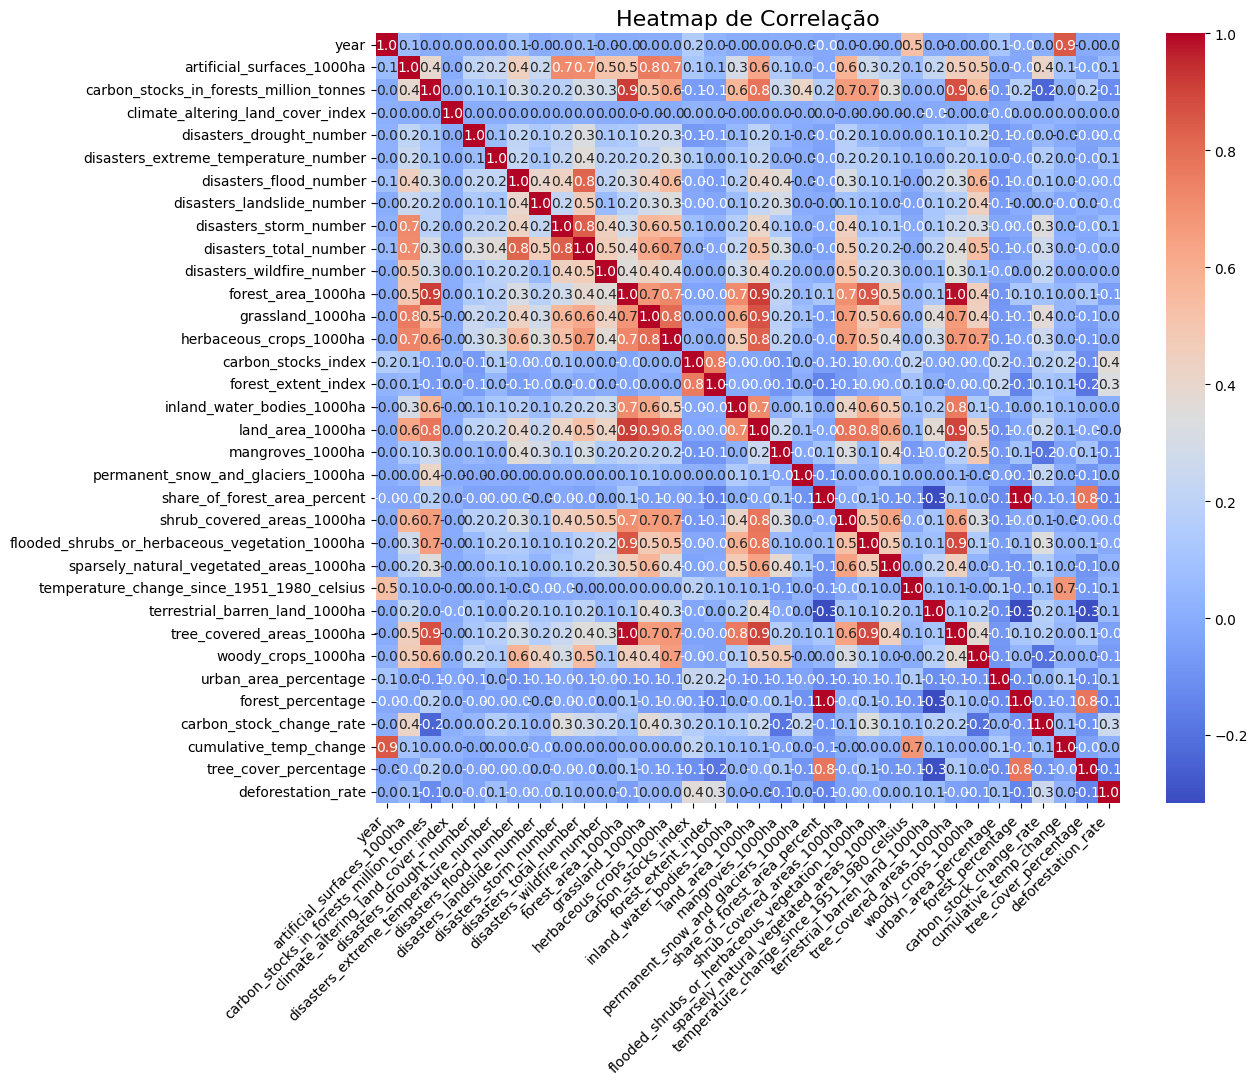

In [ ]:
plt.figure(figsize=(12, 10))  # Ajusta o tamanho do gráfico
sns.heatmap(new_corr, annot=True, cmap='coolwarm', fmt=".1f")  # Reduz para 2 casas decimais
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo X
plt.yticks(rotation=0)  # Mantém os rótulos do eixo Y horizontais
plt.title('Heatmap de Correlação', fontsize=16)  # Adiciona um título
plt.show()

## Correlação por países

Uma pergunta que pode surgir é: os dados se comportam igualmente (correlação) para os países? Levando isso em consideração, pode ser feito um heatmap para cada país, de modo a entender melhor os comportamentos.

É esperado que os comportamentos ambientais e climáticos sejam diferentes em cada país, isso porque a incidência solar, chuvas, ventos e etc são diferentes em cada região do globo. Além disso, aspectos humanos como a urbanização tendem a afetar diretamente essas condições.

In [ ]:
countries = new_data['country'].unique()
len(countries)

232

In [ ]:
countries

array(['Afghanistan, Islamic Rep. of', 'Albania', 'Algeria',
       'American Samoa', 'Andorra, Principality of', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Argentina', 'Armenia, Rep. of',
       'Aruba, Kingdom of the Netherlands', 'Australia', 'Austria',
       'Azerbaijan, Rep. of', 'Bahamas, The', 'Bahrain, Kingdom of',
       'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Belgium', 'Belize',
       'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Rep.', 'Chad', 'Chile', 'China, P.R.: Hong Kong',
       'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia',
       'Comoros, Union of the', 'Congo, Dem. Rep. of the',
       'Congo, Rep. of', 'Cook Islands', 'Costa Rica', 'Croatia, Rep. of',
       'Cuba', 'Cyprus', 'Czech Rep.', "Côte d'

Seria inviável analisar 232 heatmaps, por isso, vamos plotar apenas 4.

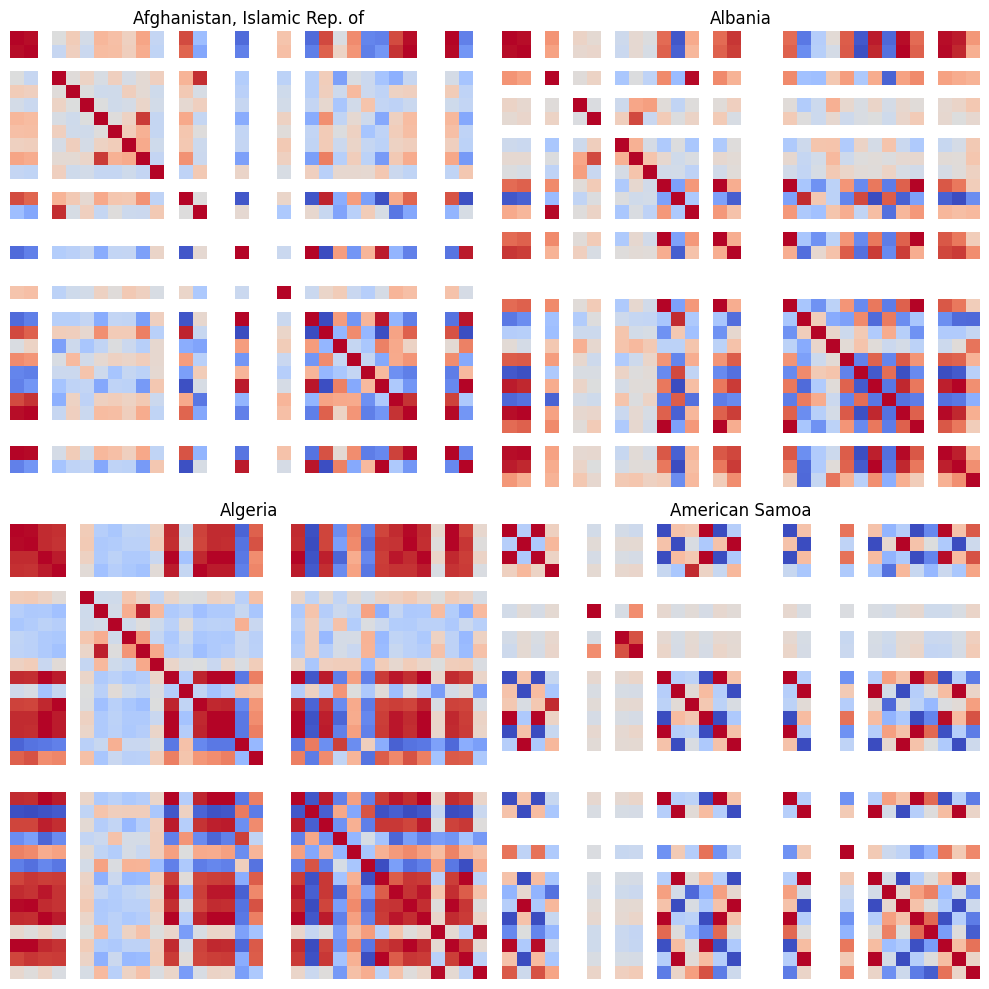

In [ ]:
# Configurar o número de colunas no layout
num_columns = 2  # Quantos heatmaps por linha
countries = new_data['country'].unique()[:4]  # Selecionar os primeiros 10 países para exemplificar

# Criar subplots
num_rows = (len(countries) + num_columns - 1) // num_columns  # Calcular o número de linhas
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 5))
axes = axes.flatten()  # Transformar a matriz de eixos em um vetor

# Iterar sobre os países e gerar os heatmaps
for i, country in enumerate(countries):
    # Filtrar os dados para o país atual
    country_data = new_data[new_data['country'] == country]

    # Selecionar apenas colunas numéricas
    numeric_columns = country_data.select_dtypes(include='number').columns
    country_numeric_data = country_data[numeric_columns]

    # Calcular a matriz de correlação
    country_corr = country_numeric_data.corr()

    # Plotar o heatmap no subplot correspondente
    sns.heatmap(
        country_corr, 
        annot=False, 
        cmap='coolwarm', 
        ax=axes[i], 
        cbar=False  # Ocultar a barra de cores individualmente
    )
    axes[i].set_title(country, fontsize=12)
    axes[i].axis('off')  # Opcional: remover os rótulos dos eixos

# Ajustar o layout e remover subplots vazios
for j in range(len(countries), len(axes)):
    fig.delaxes(axes[j])  # Remove os eixos não utilizados

plt.tight_layout()
plt.show()

Com o resultado obtido a partir dos 4 heatmaps, percebe-se que realmente há grandes variações na correlação de variáveis para cada país. Isso mostra que, para casos de predição, por exemplo, seria importante analisar individualmente cada país.

## Perguntas iniciais para entendimento dos dados

### Qual país mais teve desastres naturais nos últimos 5 anos?

In [ ]:
# Filtrar os últimos 5 anos (ajuste o ano atual conforme necessário)
latest_year = new_data['year'].max()
last_5_years = new_data[new_data['year'] >= (latest_year - 5)]

# Agrupar por país e somar o número total de desastres
disasters_by_country = last_5_years.groupby('country')['disasters_total_number'].sum()
most_disasters_country = disasters_by_country.idxmax()
most_disasters_count = disasters_by_country.max()

print(f"O país com mais desastres naturais nos últimos 5 anos foi {most_disasters_country}, com {most_disasters_count} desastres.")

O país com mais desastres naturais nos últimos 5 anos foi United States, com 154.0 desastres.


### Quais os principais tipos de desastres naturais?


In [ ]:
# Selecionar colunas de desastres
disaster_columns = [
    'disasters_drought_number', 
    'disasters_extreme_temperature_number', 
    'disasters_flood_number', 
    'disasters_landslide_number', 
    'disasters_storm_number', 
    'disasters_wildfire_number'
]

# Somar ocorrências de cada tipo de desastre
disaster_totals = new_data[disaster_columns].sum().sort_values(ascending=False)

print("Principais tipos de desastres naturais:")
print(disaster_totals)

Principais tipos de desastres naturais:
disasters_flood_number                  4548.0
disasters_storm_number                  3047.0
disasters_landslide_number               558.0
disasters_extreme_temperature_number     520.0
disasters_drought_number                 489.0
disasters_wildfire_number                369.0
dtype: float64


### Em qual ano ocorreram mais desastres?


In [ ]:
# Agrupar por ano e somar o número total de desastres
disasters_by_year = new_data.groupby('year')['disasters_total_number'].sum()
year_with_most_disasters = disasters_by_year.idxmax()
most_disasters_in_year = disasters_by_year.max()

print(f"O ano com mais desastres foi {year_with_most_disasters}, com {most_disasters_in_year} desastres.")

O ano com mais desastres foi 2005, com 406.0 desastres.


### Há uma tendência de aumento no número de desastres ao longo dos anos?


In [ ]:
#Agrupar por ano e calcular o número total de desastres
disasters_by_year = new_data.groupby('year')['disasters_total_number'].sum()

# Realizar a regressão linear
years = disasters_by_year.index
disasters = disasters_by_year.values
slope, intercept, r_value, p_value, std_err = linregress(years, disasters)

# Previsão da linha de tendência
trend_line = slope * years + intercept

# Exibir resultados
trend = "aumento" if slope > 0 else "diminuição"
print(f"A tendência é de {trend} no número de desastres ao longo dos anos.")
print(f"Coeficiente angular: {slope:.2f}, R²: {r_value**2:.2f}, p-value: {p_value:.4f}")

A tendência é de aumento no número de desastres ao longo dos anos.
Coeficiente angular: 4.09, R²: 0.37, p-value: 0.0003


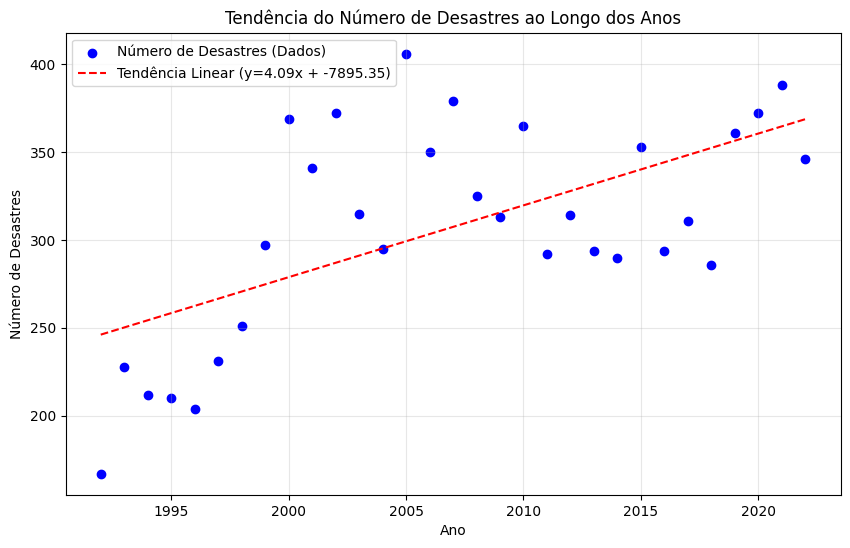

In [ ]:
# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.scatter(years, disasters, color='blue', label='Número de Desastres (Dados)')
plt.plot(years, trend_line, color='red', linestyle='--', label=f'Tendência Linear (y={slope:.2f}x + {intercept:.2f})')
plt.title('Tendência do Número de Desastres ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Desastres')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Predição de comportamentos climáticos e ambientais no Brasil

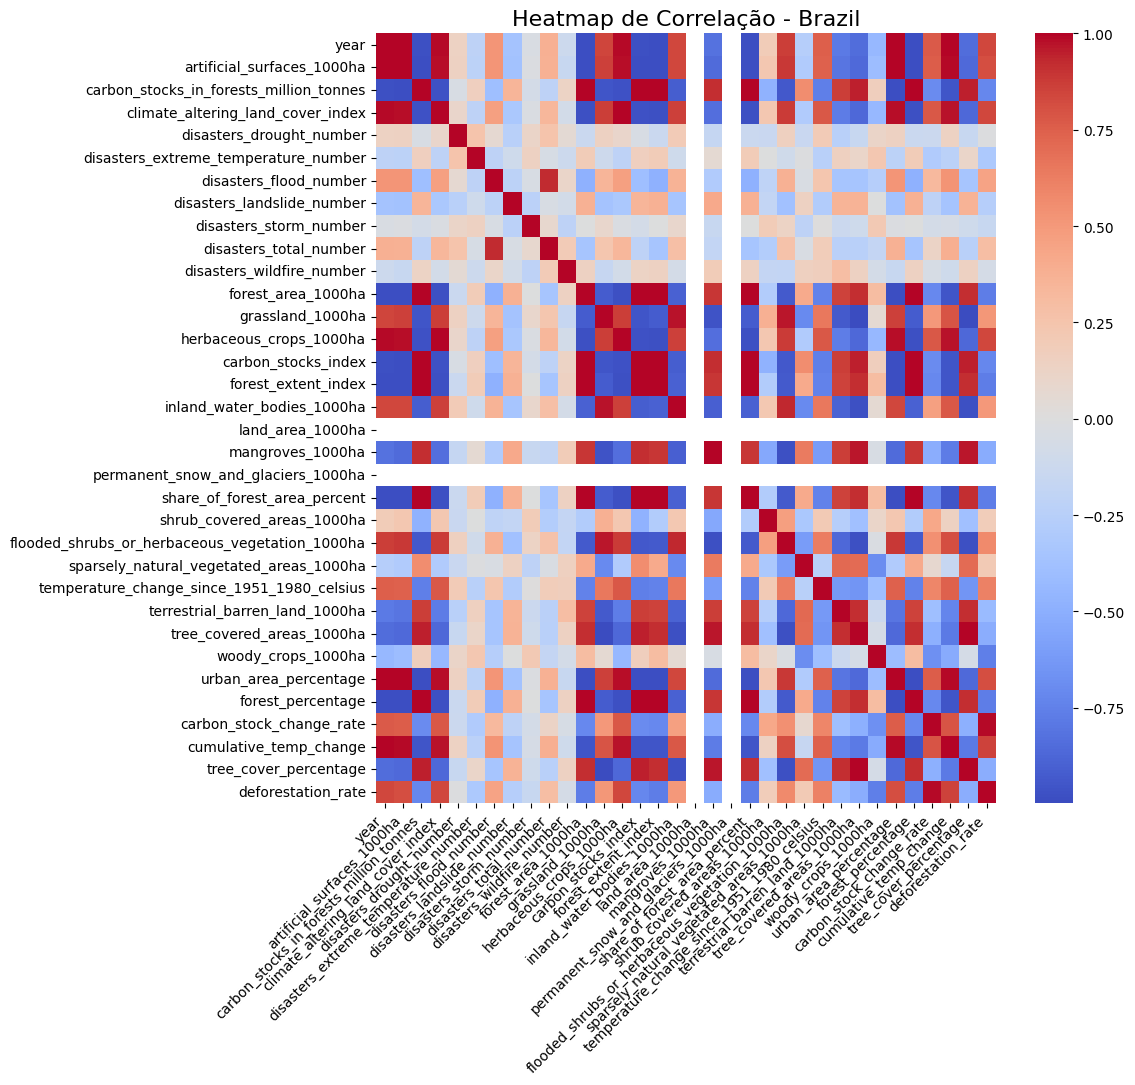

In [ ]:
# Filtrar os dados para o país atual
country_data = new_data[new_data['country'] == 'Brazil']
    
# Selecionar apenas colunas numéricas
numeric_columns = country_data.select_dtypes(include='number').columns
country_numeric_data = country_data[numeric_columns]
    
# Calcular a matriz de correlação
country_corr = country_numeric_data.corr()
    
# Plotar o heatmap de correlação para o país
plt.figure(figsize=(10, 10))
sns.heatmap(country_corr, annot=False, cmap='coolwarm')  # Remover números no gráfico
plt.title(f'Heatmap de Correlação - Brazil', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
count += 1

Com base na matriz e na utilidade das variáveis, existem variáveis que fazem mais sentido em serem previstas, como a mudança acumulada de temperatura. Ela mostra o quanto a temperatura está aumentando ou diminuindo ao longo dos anos.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
relevant_features = ['artificial_surfaces_1000ha', 'forest_area_1000ha', 
                     'carbon_stocks_in_forests_million_tonnes', 'deforestation_rate', 
                     'tree_covered_areas_1000ha']  
target = 'cumulative_temp_change'

In [ ]:
brazil_data = new_data[new_data['country'] == 'Brazil']
brazil_data

,country,iso2,iso3,year,artificial_surfaces_1000ha,carbon_stocks_in_forests_million_tonnes,climate_altering_land_cover_index,disasters_drought_number,disasters_extreme_temperature_number,disasters_flood_number,...,temperature_change_since_1951_1980_celsius,terrestrial_barren_land_1000ha,tree_covered_areas_1000ha,woody_crops_1000ha,urban_area_percentage,forest_percentage,carbon_stock_change_rate,cumulative_temp_change,tree_cover_percentage,deforestation_rate
1594,Brazil,BR,BRA,1992,998.78,58129.1412,84.836486,0.0,0.0,4.0,...,0.435,451.75,470206.64,23882.62,0.119498,69.553288,NaN,0.435,56.257330,NaN
1595,Brazil,BR,BRA,1993,1029.43,57845.9800,85.223740,0.0,0.0,0.0,...,0.525,451.87,467962.32,24155.10,0.123165,69.100922,-283.1612,0.960,55.988811,-0.452366
1596,Brazil,BR,BRA,1994,1056.18,57562.8187,85.133562,1.0,1.0,0.0,...,0.623,451.70,467966.00,24297.77,0.126365,68.648556,-283.1613,1.583,55.989251,-0.452366
1597,Brazil,BR,BRA,1995,1086.01,57279.6575,88.466679,0.0,0.0,3.0,...,0.808,448.51,463578.34,22612.64,0.129934,68.196190,-283.1612,2.391,55.464295,-0.452366
1598,Brazil,BR,BRA,1996,1116.48,56996.4963,88.929263,0.0,0.0,1.0,...,0.530,449.39,461485.82,23540.39,0.133580,67.743823,-283.1612,2.921,55.213938,-0.452366
1599,Brazil,BR,BRA,1997,1145.32,56713.3351,89.252887,0.0,0.0,3.0,...,0.738,446.49,459665.94,24416.61,0.137030,67.291457,-283.1612,3.659,54.996200,-0.452366
1600,Brazil,BR,BRA,1998,1175.66,56430.1738,89.914556,1.0,0.0,5.0,...,1.267,445.23,456943.33,25373.53,0.140660,66.839091,-283.1613,4.926,54.670457,-0.452366
1601,Brazil,BR,BRA,1999,1207.20,56147.0126,91.155797,0.0,0.0,1.0,...,0.566,443.50,453109.18,26491.16,0.144434,66.386725,-283.1612,5.492,54.211724,-0.452366
1602,Brazil,BR,BRA,2000,1240.02,55863.8514,91.016075,0.0,1.0,4.0,...,0.538,437.23,452703.38,27193.03,0.148361,65.934359,-283.1612,6.030,54.163173,-0.452366
1603,Brazil,BR,BRA,2001,1310.39,55563.6296,91.118373,1.0,0.0,3.0,...,0.802,382.32,451528.67,27940.41,0.156780,65.461671,-300.2218,6.832,54.022626,-0.472688


In [ ]:
features = [col for col in relevant_features if col in brazil_data.columns]

In [ ]:
features

['artificial_surfaces_1000ha',
 'forest_area_1000ha',
 'carbon_stocks_in_forests_million_tonnes',
 'deforestation_rate',
 'tree_covered_areas_1000ha']

In [ ]:
# Filtrar dados e remover valores nulos
data_brazil_filtered = brazil_data[features + [target]].dropna()
data_brazil_filtered

,artificial_surfaces_1000ha,forest_area_1000ha,carbon_stocks_in_forests_million_tonnes,deforestation_rate,tree_covered_areas_1000ha,cumulative_temp_change
1595,1029.43,577555.18,57845.9800,-0.452366,467962.32,0.960
1596,1056.18,573774.24,57562.8187,-0.452366,467966.00,1.583
1597,1086.01,569993.30,57279.6575,-0.452366,463578.34,2.391
1598,1116.48,566212.36,56996.4963,-0.452366,461485.82,2.921
1599,1145.32,562431.42,56713.3351,-0.452366,459665.94,3.659
1600,1175.66,558650.48,56430.1738,-0.452366,456943.33,4.926
1601,1207.20,554869.54,56147.0126,-0.452366,453109.18,5.492
1602,1240.02,551088.60,55863.8514,-0.452366,452703.38,6.030
1603,1310.39,547137.81,55563.6296,-0.472688,451528.67,6.832
1604,1372.56,543187.02,55263.4079,-0.472688,450573.75,7.914


In [ ]:
# Separar X (variáveis independentes) e y (variável alvo)
X = data_brazil_filtered[features]
y = data_brazil_filtered[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor()
}

In [ ]:
# Parâmetros de Grid Search
param_grids = {
    "LinearRegression": {},
    "Ridge": {'model__alpha': [0.1, 1.0, 10.0]},
    "Lasso": {'model__alpha': [0.01, 0.1, 1.0]},
    "RandomForest": {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 10, 20]},
    "GradientBoosting": {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.5]}
}

In [ ]:
results = {}
for name, model in models.items():
    pipeline.set_params(model=model)
    param_grid = param_grids[name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Melhor modelo e avaliação
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'BestModel': best_model, 'MSE': mse, 'R2': r2}

In [ ]:
results_df = pd.DataFrame({name: data for name, data in results.items()}).T
print(results_df)

                                                          BestModel       MSE  \
LinearRegression             (StandardScaler(), LinearRegression())  0.861419   
Ridge                          (StandardScaler(), Ridge(alpha=0.1))   1.05931   
Lasso                         (StandardScaler(), Lasso(alpha=0.01))  1.185066   
RandomForest      (StandardScaler(), (DecisionTreeRegressor(max_...  0.418184   
GradientBoosting  (StandardScaler(), ([DecisionTreeRegressor(cri...   0.73887   

                        R2  
LinearRegression  0.987131  
Ridge             0.984175  
Lasso             0.982296  
RandomForest      0.993753  
GradientBoosting  0.988962  


In [ ]:
# Gráfico de comparação de R²
plt.figure(figsize=(8, 5))
r2_scores = results_df['R²']

# Configurar barras e escala do eixo Y
plt.bar(r2_scores.index, r2_scores.values, color='teal')
plt.title('Comparação de R² entre Modelos')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

# Ajustar o limite do eixo Y para focar nos valores
min_r2 = r2_scores.min() - 0.01  # Um pouco abaixo do mínimo
max_r2 = r2_scores.max() + 0.01  # Um pouco acima do máximo
plt.ylim(min_r2, max_r2)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Melhor modelo - Gráfico de Valores Reais vs Previstos
best_model_name = max(results, key=lambda x: results[x]['R²'])
best_model = results[best_model_name]['BestModel']
y_pred_best = best_model.predict(X_test)

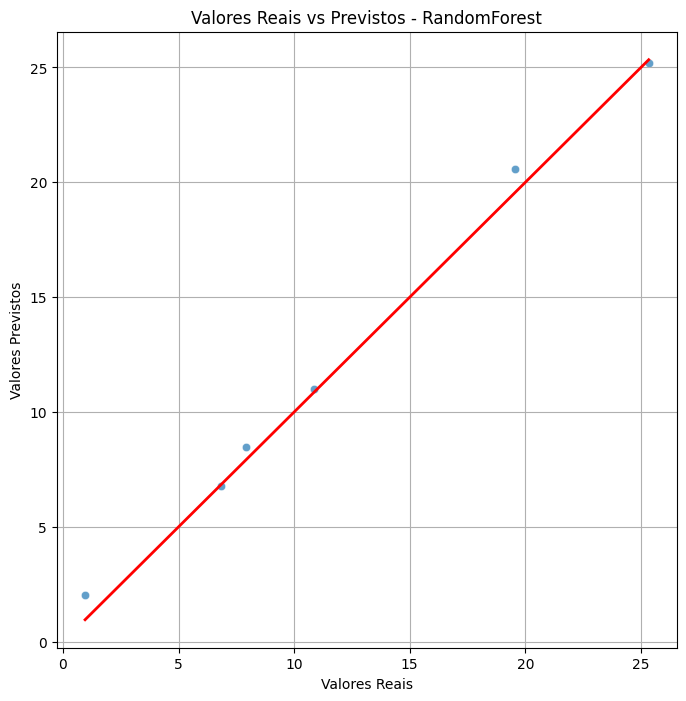

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title(f'Valores Reais vs Previstos - {best_model_name}')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.grid()
plt.show()